This is the notebook that includes the procedures for machine learning to be used in the Determinant Quantum Monte Carlo simulation

# MACHINE LEARNING IMPORTS
--------------------

In [2]:
# standard
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import math
import os
import random
%matplotlib inline


In [1]:
# import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization, Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D, AveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD, Adam
from keras.metrics import MeanAbsoluteError, MeanAbsolutePercentageError, MeanSquaredError
from keras.callbacks import History
from keras import callbacks
from keras import losses
from keras import Input, Model
from keras import regularizers
from keras import initializers, optimizers
from plot_keras_history import plot_history
from tqdm.keras import TqdmCallback

# tensorflow
import tensorflow as tf
from tensorflow.python.client import device_lib
from tensorflow.keras.utils import plot_model
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, Rescaling
print(device_lib.list_local_devices())

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16306246179985105487
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5060693856
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5759429513790619570
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1060, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


# DEFINITIONS 

In [3]:
markers = itertools.cycle(['o','s','v', ',', '+', '.', 'o', '*'])
TWOPI = math.pi * 2
colors_ls = list(mcolors.TABLEAU_COLORS)[:30]
colors = itertools.cycle(sns.color_palette())
TWOPI = math.pi * 2


kPSep = os.sep

resultsFolder = f'D:{kPSep}Uni{kPSep}SEMESTERS{kPSep}PRACE{kPSep}CONDENSED_GROUP_CLOUD_UNI{kPSep}DQMC{kPSep}DQMC'
print("results folder : ", resultsFolder)
directory_path = os.getcwd()
print("directory path : ", directory_path)

results folder :  D:\Uni\SEMESTERS\PRACE\CONDENSED_GROUP_CLOUD_UNI\DQMC\DQMC
directory path :  D:\Uni\SEMESTERS\PRACE\CONDENSED_GROUP_CLOUD_UNI\DQMC\DQMC\Python\ml


------------------
# OTHERS
______________________

Check if the directories from the list are existing and if not create them

In [4]:
def createFolder(directories):
    for folder in directories:
        try:
            if not os.path.isdir(folder):
                os.makedirs(folder)
                print("Created a directory : ", folder)
        except OSError:
            print("Creation of the directory %s failed" % folder)      
# Guard against race condition
        except OSError as exc: 
            if exc.errno != errno.EEXIST:
                raise

In [5]:
dat = lambda x : x.endswith('.dat')
def readRandomFile(folder, cond, withoutFolder = False):
    choice = random.choice(os.listdir(folder))
    #print(choice)
    maxlen = len(os.listdir(folder))
    counter = 0
    while not cond(choice):
        choice = random.choice(os.listdir(folder))
        if counter > maxlen:
            raise
        counter += 1
    if withoutFolder:
        return choice
    else:
        return folder + choice

In [6]:
def justPrinter(file,sep="\t", elements =[], width = 8, endline = True):
    for item in elements:
        file.write((str(item) + sep).ljust(width))
    if endline:
        file.write("\n")

In [7]:
def averageColsFromFolder(folder, avNum, tmp, cols, which_col):
    
    tmp_squared = tmp * tmp
    for i in range(avNum - 1):
        choice = readRandomFile(folder, dat, withoutFolder = True)  
        a = np.array(pd.read_csv(folder + choice,header = None, names = cols,\
                                 index_col = 0, sep = '\t', encoding = 'utf-8')[which_col])
        tmp += a
        tmp_squared += a * a 
    tmp /= avNum
    tmp_squared /= avNum
    tmp_squared = np.sqrt(-np.power(tmp, 2) + tmp_squared)
    # return average and std
    return tmp_squared

----------------------------
# CLASSES CONTAINING ALL INFO ABOUT MODELS

The HubbardQR model that directly corresponds to the model in the C++ simulation

In [8]:
class HubbardDQMC:
    N = 1
    M = 1
    def __init__(self, M, M_0, U, mu, beta, lattice_type, Lx, Ly, Lz = 1, dim = 2):
        self.M = M
        self.M_0 = M_0
        self.dtau = beta/M
        self.lambd = math.acosh(math.exp((abs(U) * self.dtau) * 0.5));
        # physical
        self.beta = beta
        self.T = 1.0/beta
        self.U = U
        self.mu = mu
        # lattice
        self.lat_type = lattice_type
        self.dim = dim
        self.Lx = Lx
        self.Ly = Ly
        self.Lz = Lz
        self.N = Lx*Ly*Lz
        self.directory = "results" + kPSep 
        
    def getInfo(self):
        return f'M={self.M},M0={self.M_0},dtau={self.dtau:.2f},Lx={self.Lx},Ly={self.Ly},Lz={self.Lz},beta={self.beta:.2f},U={self.U:.2f},mu={self.mu:.2f}' 

    
    def getDirectory(self):
        LxLyLz = f'Lx={self.Lx},Ly={self.Ly},Lz={self.Lz}'       
        return self.directory + self.lat_type + kPSep + str(self.dim) + "D" + kPSep + LxLyLz + kPSep
    
    def makeRandomConfig(self):
        return np.random.randint(2,size=(self.N, self.M, 1))

------------------
# IMAGES
______________________

In [9]:
from PIL import Image
from shutil import copyfile

### CREATE IMAGES FROM CONFIGURATIONS SAVED TO A FILE

In [10]:
# conditions
config_cond = lambda x: x.endswith(".dat") and (x.startswith("neg_") or x.startswith("pos_"))

# functions
def imgFromConfig(directory,savedir="."+kPSep, lines=False, cond = lambda x : x, deleteFile = False, silent = False):
    createFolder([savedir], silent)
    for filename in filter(cond, os.listdir(directory)):
        # read data
        imArray = np.loadtxt(directory + filename)
        # check if we have only one row
        if imArray.ndim == 1:
            imArray = np.array([ar])
        # plot with axes
        if lines:
            x, y = np.linspace(0, len(ar[0]) - 1, len(ar[0])), np.linspace(0, len(ar) - 1, len(ar))
            plt.gca().set_xticks(x)
            plt.gca().set_xticklabels([str(i) if i % 10 == 0 else '' for i in x], rotation=90)
            plt.gca().set_yticks(y)
            plt.gca().set_yticklabels([str(i) if i % 10 == 0 else '' for i in y], rotation=45)
            plt.imshow(imArray, interpolation='none')
            plt.savefig(saveFolder + filename[:-4] + '.png')
        else:
            image = Image.fromarray(np.uint8(imArray * 255), "L") # .convert('RGB').resize(max_size, resample=Image.BOX)
            image.save(savedir + filename[:-4] + '.png')
        if deleteFile:
            os.remove(directory + filename)

--------
# HELPERS
------

### SHUFFLE TO FILES TO DIFFERENT DIRECTORIES FOR TEST, VALIDATION AND TRAINING
Here we will create the directories that will contain the filles according to specified category and will be shuffled to val, test and val folders

In [11]:
def split_data(SOURCE, TRAINING, VALIDATION, TESTING, train_siz, val_siz, silent = False):
    files = []
    # list files
    for filename in os.listdir(SOURCE):
        file = SOURCE + kPSep + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring this bud.")

    training_length = int(len(files) * train_siz)
    validation_length = int(len(files) * val_siz + 1)
    testing_length = int(len(files) - training_length - validation_length)
    
    if not silent:
        print('SOURCE: ', SOURCE, '\n TRAINING', TRAINING, '\n VALIDATION', VALIDATION, '\n ', len(files))
        print('training_length:', training_length)
        print('validation_length:', validation_length)
        print('testing_length:', testing_length)

    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    validation_set = shuffled_set[training_length:(training_length + validation_length)]
    testing_set = shuffled_set[training_length + validation_length:-1]

    # TRAIN
    for filename in training_set:
        this_file = SOURCE + kPSep + filename
        destination = TRAINING + kPSep + filename
        Path(this_file).rename(destination)

    # VAL
    for filename in validation_set:
        this_file = SOURCE + kPSep + filename
        destination = VALIDATION + kPSep + filename
        Path(this_file).rename(destination)
    # TEST
    for filename in testing_set:
        this_file = SOURCE + kPSep + filename
        destination = TESTING + kPSep + filename
        Path(this_file).rename(destination)



In [12]:
def shuffleToTestValidTrain(directory, train_size, val_size, classes = [''], removeFolders = False, silent = False):
    # path to the source files
    source_path = [directory + a for a in classes]
    # set TRAIN VALIDATION AND TEST FOLDERS
    TRAIN_VAL_TEST = ['train', 'val', 'testing']
    TRAIN_VAL_TEST = [directory + a + kPSep for a in TRAIN_VAL_TEST]
    createFolder(TRAIN_VAL_TEST)
    # set folders with classes
    train_path = [TRAIN_VAL_TEST[0] + a  for a in classes]
    val_path = [TRAIN_VAL_TEST[1] + a  for a in classes]
    test_path = [TRAIN_VAL_TEST[2] + a  for a in classes]
    createFolder(train_path + val_path + test_path)  
    # TRY TO SPLIT FILES
    if not silent:
        print('\tSPLITTING DATA')
    for source, train_dir_path, val_dir_path, test_dir_path in zip(source_path, train_path, val_path, test_path):
        split_data(source, train_dir_path, val_dir_path, test_dir_path, train_size, val_size)
    if removeFolders:
        for folder in source_path:
            os.rmdir(folder)


-------------------
# NETWORKS 
--------------------


### 2D CONVOLUTION
--------
Below the network for 2d convolion is created, the files are taken from directories, that are split up before

In [13]:
def createModel2D_CONV(directory, width, height, epo=4, batch=10,categories=[], color = "grayscale"):
    DATASET_LOCATION = directory
    BATCH_SIZE = batch
    IMAGE_SIZE = (width, height)
    SHAPE = (width, height, 1)
    EPOCHS = epo
    train = directory + "train" + kPSep
    val = directory + "val"+kPSep
    test = directory + "testing" + kPSep

    
    train_dataset =  tf.keras.preprocessing.image_dataset_from_directory(
        directory = train,
        class_names = categories,
        color_mode = color,
        validation_split = 0,
        seed=1337,
        image_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
    )
    val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        directory = val,
        class_names = categories,
        color_mode = color,
        validation_split = 0,
        seed=1337,
        image_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
    )
    test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        directory = test,
        class_names = categories,
        color_mode = color,
        validation_split = 0,
        seed=1337,
        image_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
    )
     
# NOW WE MAKE NETWORK
    inputs = Input(SHAPE)
    #x = data_augmentation(inputs)
    #x = Rescaling(1./255)(inputs)
# first layer
    x = layers.Conv2D(filters=32, kernel_size=(3,3), activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D(2, 2, padding="valid")(x)
# second layer
    x = layers.Dropout(0.4)(x)
    x = layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2, 2, padding="valid")(x)
# third layer
    x = layers.Dropout(0.4)(x)
    x = layers.Conv2D(64, (3, 3), activation='relu',kernel_initializer=initializers.random_normal(), padding="valid",bias_initializer=initializers.zeros())(x)
    x = layers.MaxPooling2D(2, 2, padding="valid")(x)
# fourth layer
    x = layers.Dropout(0.4)(x)
    x = layers.Conv2D(128, (3, 3), activation='relu',kernel_initializer=initializers.random_normal(), padding="valid",bias_initializer=initializers.zeros())(x)
    #x = layers.BatchNormalization()(x)
# hidden
    x = layers.Dropout(0.4)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)    
    outputs = (layers.Dense(units=1, activation="sigmoid"))(x)
    model = Model(inputs, outputs, name="2Dcnn")
# Define the model.
    model.summary()
# Compile model.
    initial_learning_rate = 0.0001
    lr_schedule = tf.optimizers.schedules.ExponentialDecay(
        initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
    )
    model.compile(
        loss="binary_crossentropy",
        optimizer=Adam(learning_rate=lr_schedule),
        metrics=["acc"],
    )
# Define callbacks.
    checkpoint_cb = keras.callbacks.ModelCheckpoint("2d_image_classification.h5", save_best_only=True)
    early_stopping_cb = callbacks.EarlyStopping(monitor="val_acc", patience=15)
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=EPOCHS,
        verbose=2,
        callbacks=[checkpoint_cb, early_stopping_cb]
    )
    #plot_results(history, save_dir=directory)
    #keras.utils.plot_model(model, show_shapes=True)
    plt.figure(figsize=(12, 16))
    plot_history(history, path=directory + "test.png")


### 2D REGRESSION
--------

In [14]:
def createModel2D_REG(directory, width, height, epo=4, batch=10,categories=[], color = "grayscale", load_model = False, silent = False):
    DATASET_LOCATION = directory
    BATCH_SIZE = batch
    IMAGE_SIZE = (width, height)
    SHAPE = (width, height, 1)
    EPOCHS = epo
    train = directory + "train" + kPSep
    val = directory + "val"+kPSep
    test = directory + "testing" + kPSep
    len_up = len(os.listdir(train+categories[1]))
    len_down = len(os.listdir(train+categories[0]))
    savename = directory + "2d_image_classification.h5"
    
    train_dataset =  tf.keras.preprocessing.image_dataset_from_directory(
        directory = train,
        class_names = categories,
#        class_mode='categorical',
        color_mode = color,
        validation_split = 0,
        seed=1337,
        image_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
    )
    val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        directory = val,
        class_names = categories,
        color_mode = color,
#        class_mode='categorical',
        validation_split = 0,
        seed=1337,
        image_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
    )
    test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        directory = test,
#        class_mode ='categorical',
        class_names = categories,
        color_mode = color,
        validation_split = 0,
        seed=1337,
        image_size=IMAGE_SIZE,
        batch_size=1,
    )
     
# NOW WE MAKE NETWORK
    inputs = Input(SHAPE)
    #x = data_augmentation(inputs)
    #x = Rescaling(1./255)(inputs)
# first layer
    x = layers.Conv2D(filters=16, kernel_size=(3,3), activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D(2, 2, padding="valid")(x)
# second layer
    #x = layers.Conv2D(32, (3, 3), activation='relu',kernel_initializer=initializers.random_normal(), padding="valid",bias_initializer=initializers.zeros())(x)
    #x = layers.BatchNormalization()(x)
    #x = layers.MaxPooling2D(2, 2)(x)
    
# third layer
    #x = layers.Conv2D(64, (3, 3), activation='relu',kernel_initializer=initializers.random_normal(), padding="valid")(x)
    #x = layers.MaxPooling2D(2, 2)(x)
# hidden
    x = Flatten()(x)
    x = Dense(128, activation="selu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.35)(x)
    x = layers.Dense(24, activation='relu')(x)
    outputs = (layers.Dense(units=len(categories), activation="softmax"))(x)
    model = Model(inputs, outputs, name="regression")
# Define the model.
    model.summary()
# Compile model.
    sgd = SGD(lr=0.001, decay=1e-5, momentum=0.9, nesterov=True)
    model.compile(
        loss=keras.losses.sparse_categorical_crossentropy,
        optimizer=sgd,#Adam(lr=1e-3, decay=1e-3 / 200),
        metrics=["acc"],
    )
# Define callbacks.
    checkpoint_cb = keras.callbacks.ModelCheckpoint(savename, save_best_only=True)
    early_stopping_cb = callbacks.EarlyStopping(monitor="val_acc", patience=25)
    print("\n\ntraining regression model, av_sign is: " + str((len_up - len_down)/(len_up + len_down)) + "\n\n\n")
    print("\t\t->positive percentage is: " + str((len_up)/(len_up + len_down)) + "\n\n\n")
    print("\t\t->negative percentage is: " + str((len_down)/(len_up + len_down)) + "\n\n\n")
    if not load_model:
        history = model.fit(
            train_dataset,
            validation_data=val_dataset,
            epochs=EPOCHS,
            verbose=0,
            callbacks= [TqdmCallback(verbose = 1), checkpoint_cb, early_stopping_cb]
        )
        plt.figure(figsize=(12, 16))
        plot_history(history, path=directory + "test.png")
    else:
        model = keras.models.load_model(savename)
    
    
    # tescik
    
    predictions = model.predict(test_dataset)
    labels = []
    for x, y in test_dataset:
        labels.append(np.array(y))
    labels = np.array(labels).flatten()
    counter = 0
    preds = []
    for i in range(len(predictions)):
        wrong = "\t I AM \033[1;32m RIGHT \033[1;0m ! ! !"
        counter += 1
        preds.append(np.argmax(predictions[i]))
        if np.argmax(predictions[i]) != int(labels[i]):
            wrong = "\t I AM \033[1;31m WRONG \033[1;0m ! ! !"
            counter -= 1
        print("\033[1;0",predictions[i], "label = ", labels[i], wrong)
        
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(labels, np.array(preds))
    plt.plot(fpr_keras,tpr_keras)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    auc_keras = auc(fpr_keras, tpr_keras)
    plt.plot(auc_keras)
    plt.savefig(directory + "roc.png",facecolor='w')
    plt.show()
    print(f'\033[1;36m \n\n\t--------------------\tTest accuracy is {counter/len(predictions)}\t--------------------\n\n')
    
    return model
    

------------
## AUTOENCODERS
--------------------


### AUTOENCODER
----------
Here we provide the standard autoencoder function that returns normal model with changable inner layers number

In [2]:
def autoEnc(latent_dim, shape, nlayers=1, alfa=0.1, activation = keras.activations.relu):
    print(f"creating #layers = {nlayers} with input shape {shape}")
    input_size = shape[1]
    compression = int(input_size * latent_dim / input_size)
    # integer division
    reduction = compression // nlayers
    # check if there is to many layers
    if input_size - (nlayers - 1) * reduction <= 0:
        print(f"to many layers {nlayers} for compression {compression}")

    # ------ encoder
    inputer = Input(input_size)
    encoder = None
    if nlayers == 1:
        # shap = (None
        encoder = tensorflow.keras.layers.Dense(input_size - (nlayers - 1) * reduction,
                               activation=tensorflow.keras.activations.sigmoid, name = "sigmoidLayer")(inputer)
        # we must have size bigger than 0 so check maximum for those number of layers
    else:
        # add linear layer
        encoder = layers.Dense(input_size - reduction,
                               activation=tensorflow.keras.layers.LeakyReLU(alpha=alfa), name = "startingLeakyRelu")(inputer)
        # add leaky relus
        counter = 2
        for i in range(nlayers - 3):
            encoder = layers.Dense(input_size - counter * reduction,
                                   activation= tensorflow.keras.layersLeakyReLU(alpha=alfa))(encoder)
            counter += 1

        # add last dense layer
        encoder = layers.Dense(input_size - (nlayers - 1) * reduction,
                               activation=tensorflow.keras.activations.sigmoid, name = "sigmoidLayer")(encoder)

    
    decoder = None
    if nlayers == 1:
        decoder = layers.Dense(input_size, activation=tensorflow.keras.activations.sigmoid)(encoder)
        # we must have size bigger than 0 so check maximum for those number of layers
    else:
        counter = nlayers - 1
        decoder = layers.Dense(input_size - counter * reduction, activation=tensorflow.keras.layers.LeakyReLU(alpha=alfa))(encoder)

        counter -= 1
        for i in range(nlayers - 2):
            decoder = layers.Dense(input_size - counter * reduction, activation=tensorflow.keras.layers.LeakyReLU(alpha=alfa))(decoder)
            counter -= 1

       # add last dense layer
        decoder = layers.Dense(input_size, activation=tensorflow.keras.activations.sigmoid)(decoder)


    decod_M = keras.Model(inputer, decoder, name="autoencoder")

    return decod_M

NameError: name 'keras' is not defined

-------------------
# NETWORK USERS

-------
### AUTOENCODING FROM DATA

In [17]:
def fileAutoencode(directory, model, latent_dim, epo, trainsize, testsize = 5,batch = 10, x = 1, y = 1, \
                   verbose = 2, createFiles = True, loss = 'mean_squared_error',\
                   activation = 'relu', savename = 'model', train = True):
    # take the folder
    Lx = model.Lx
    Ly = model.Ly


    folder = directory + kPSep + model.getDirectory() + "greens" + kPSep + model.getInfo() + kPSep + "times" + kPSep
    files = set(os.listdir(folder))
    # create files if necessary
    if createFiles:  
        for i in range(trainsize + testsize):
            names = [filename for filename in files if filename.startswith(f"{i}-") and filename.endswith(".dat")]

            if len(names) > 0:
                readTimeDisplacedGreens(folder, model.M, names , Lx, Ly)
                
    # change into the folder
    folder = folder + "posDiff" + kPSep + str((x, y)) + kPSep
    filenum = len(files)
    data_train = []
    data_test = []
    counter = 0

    # read files
    for filename in filter(lambda x: x.endswith('.dat'), os.listdir(folder)):
        tmp = pd.read_csv(folder + filename,header = None, names = ['M', 'val', 'err'], sep = '\t')
        if counter > filenum:
            break
        elif counter < trainsize: 
            data_train.append( np.array(tmp['val']))
        elif trainsize <= counter < trainsize + testsize:
            data_test.append( np.array(tmp['val']))
        else:
            break
        counter+=1
    
    data_train = np.array(data_train)
    data_test = np.array(data_test)

    # make autoencoder
    print(f'\n\n\t\tMaking autoencoder with loss={loss},activ={activation},latent={latent_dim}\t\t\n\n')

    autoencoder = autoEnc(latent_dim = latent_dim, shape = (model2.M,1), activation=activation)#Autoencoder(latent_dim = latent_dim, shape = (model2.M,1), activation=activation)
    autoencoder.compile(optimizer='rmsprop', loss=loss)
    checkpoint_cb = keras.callbacks.ModelCheckpoint(savename + ".h5", save_best_only=True)
    early_stopping_cb = callbacks.EarlyStopping(monitor="val_loss", patience=10)
    history = autoencoder.fit(data_train, data_train,
                epochs=epo,
                shuffle=True,
                batch_size = batch,
                validation_data=(data_test,data_test),verbose=0, callbacks = [TqdmCallback(verbose = 1), checkpoint_cb, early_stopping_cb])
    autoencoder.summary()
    if train:
        plot_history(history, path=savename+',training.png')
        print("creating h5 file: " + savename + ".h5")
        autoencoder.save(savename + ".h5", save_format='h5')
    return autoencoder

----------
### COMPARISON WITH ORIGINAL

In [18]:
def compareAutoencoder_Average(directory, model, latent_dim, epo, trainsize, x, y,subplts, batch = 10, load_model = False, testsize = 5, avNum = 5,\
                               encoderAvNum = 1, verbose = 2, createFiles = True, loss = 'mean_squared_error',\
                               activation = 'relu', scale = False, difference = mean_squared_error, theirError = 1, myError = False):
    fig,ax = subplts
    Lx = model.Lx
    Ly = model.Ly
    folder = directory + kPSep + model.getDirectory() + "greens" + kPSep + model.getInfo() + kPSep + "times" + kPSep
    originalFolder = folder
    folderComp = directory + kPSep + model.getDirectory() + "greens" + kPSep + model.getInfo() + kPSep + "times" + kPSep + "compDiff" + kPSep
    savename = folder + f'myModel_loss={loss},activ={activation},latent={latent_dim},(x,y)={str((x,y))}'
    # read comparison
    if createFiles:
        names = [readRandomFile(folderComp,lambda x: x.startswith("g") and x.endswith(".out"), True)]
        readTimeDisplacedGreens(folderComp, model.M + 1, names, Lx = Lx, Ly = Ly, skiprange = 35, end = '.out')
    
    # check if we load model or train new
    if not load_model or (load_model and not os.path.exists(savename +".h5")): 
        network = fileAutoencode(directory, model, latent_dim, epo, trainsize, testsize, batch = batch, x=x ,y=y, verbose=verbose,\
                                 createFiles=createFiles, loss = loss, savename=savename, activation = activation, train = True)
        title = f"Model trained on trainsize={trainsize}, with {batch} batches"
        savename += f',loaded={True}'
    else:
        title = f"Model loaded from : .{kPSep}{kPSep.join(savename.split(kPSep)[-4:])}.h5"
        print(f'\n\t\tloading model :\n\t{savename}.h5\n')
        network = keras.models.load_model(savename+".h5")
        savename += f',loaded={False}'
    
    folder += "posDiff" + kPSep + str((x, y)) + kPSep   
    folderComp += "posDiff" + kPSep + str((x, y)) + kPSep
    
    # read one file to test
    choice = readRandomFile(folder, dat, withoutFolder = True)
    encodeFile = choice + ""
    tmp = np.array(pd.read_csv(folder + choice,header = None, names = ['M', 'val', 'err'],\
                                 index_col = 0, sep = '\t', encoding = 'utf-8')['val'])

    
    tmp_enc = tmp.copy()
    tester = [tf.convert_to_tensor(tmp_enc)]
    #tf.convert_to_tensor
    # read files to average with
    tmp12 = averageColsFromFolder(folder, avNum, tmp, ['M', 'val', 'err'], 'val')
    
    
    # read files to average with autoencoder
    for i in range(encoderAvNum - 1):
        choice = readRandomFile(folder, dat, withoutFolder = True)
        tmp_enc = np.array(pd.read_csv(folder + choice, header = None, names = ['M', 'val', 'err'],\
                                       index_col = 0, sep = '\t', encoding = 'utf-8')['val'])
        tester.append(tf.convert_to_tensor(tmp_enc))
    image = np.array(network.predict(np.array([tester[0]]))[0])
    #print(image)
    for i in tester[1:]:
        image += np.array(network.predict(np.array([i]))[0])
    image /= len(tester)
    
    
    # comparison from USA
    fileUsa = readRandomFile(folderComp, dat, withoutFolder = True)
    tmp2 = np.array(pd.read_csv(folderComp + fileUsa,\
                                 header = None, names = ['M', 'val', 'err'], index_col = 0, sep = '\t')['val'])
    if(theirError > 1):
        tmp22 = tmp2.copy()
        tmp22err = averageColsFromFolder(folderComp, theirError, tmp22, ['M', 'val', 'err'], 'val')
    
    #print(image)
    title +=f"\nwith {difference}: {difference(image,tmp):.5f}"
    
    label = f"G($τ$,{x},{y}) after using the encoder"
    if encoderAvNum == 1:
        label += "on file : " + encodeFile
    else:
        label += ", averaged over N = " + str(encoderAvNum) + " times"
    # if we need to scale up
    if scale:
        avTheir = np.max(tmp2)
        avMine = np.max(image)#np.max(tmp['val'])
        tmp = tmp * avTheir/avMine
        image = image * avTheir/avMine
        label += f'\nThe scale is changed by scale={avTheir/avMine:.4f}'
    # testing

    #plt.clf()
    #plt.cla()
    #ax.figure(figsize=(20,20))

    fig.suptitle(title, y=0.9)
    # encoded
    ax.plot(image, label= label)
    # averaged
    label = f"G($τ$,{x},{y}) averaged over N = " + str(avNum) + " times"
    if avNum == 1:
        label += f' . From file : {choice}'
    ax.plot(tmp, label = label)
    if myError:
        xes = range(0,len(tmp))
        ax.errorbar(x=xes,y=tmp, yerr =tmp12, label = f"STD from mine over {avNum} files")
    # their
    ax.plot(tmp2, label = f"G($τ$,{x},{y}) from USA from file :\n {fileUsa}")
    if theirError > 1:
        xes = range(0,len(tmp2))
        ax.errorbar(x=xes,y=tmp2, yerr =tmp22err, label = f"STD from USA over {theirError} files")

    # sweet colors and stuff
    ax.set_xlim(0,model.M)
    ax.set_xlabel('M/d$τ$')
    ax.set_ylabel (f"G($τ$,x,y)")
    ax.legend()
    plt.savefig(f'{savename}.png', facecolor='w')
    #plt.show()
    #plt.clf()
    return network

-------------------------------------
# PREPARATION OF CONFIGURATIONS
-----------------------------------

In [19]:
def prepareSignConfigs(model,epo=4, batch=10, main_directory="./", deleteFiles = False, reg = False, load_model = False, silent = False): 
    config_dir = main_directory + model.getDirectory() + "configurations" + kPSep
    neg_dir = config_dir + model.getInfo() + kPSep + "negative" + kPSep
    pos_dir = config_dir + model.getInfo() + kPSep + "positive" + kPSep
    images_dir = config_dir + "images" + kPSep
    # make images
    imgFromConfig(neg_dir,images_dir + "negative" + kPSep, False, config_cond, deleteFiles)
    imgFromConfig(pos_dir,images_dir + "positive" + kPSep, False, config_cond, deleteFiles)
    print("\tIMAGES DO EXIST NOW")
    shuffleToTestValidTrain(images_dir, train_size = 0.6, val_size = 0.3, classes = ["negative", "positive"], removeFolders=deleteFiles, silent= silent)
    print("\t'ND THEM SHUFFL'D")
    if not reg:
        network = createModel2D_CONV(images_dir,epo=epo, batch=batch, width=model.N,height=model.M, categories=["negative", "positive"])
    else:
        network = createModel2D_REG(images_dir,epo=epo, batch=batch, width=model.N,height=model.M, categories=["negative", "positive"], load_model=  load_model, silent = silent)
        
    print(f'\033[1;36m \n\n\t--------------------\tTest some random stuff\t--------------------\n\n')
    randConfig = model.makeRandomConfig()
    print(randConfig.shape)
    randConfig = np.array([randConfig])
    print(network.predict(randConfig))

---------------------
# GREEN FUNCTIONS
---------------------

### READ UNEQUAL TIME GREENS

-------------


The function below allows the user to read the file that is saved in a triangular form starting (0,0) -> (Lx/2, 0) -> (1,1) -> (Lx/2, 1) -> (Lx/2, Ly/2) and each point has all the times printed as well $\tau \in \{0,...,M-1\}$ 

In [20]:
cond_down = lambda x : "downgreens" in x
cond_up = lambda x : "upgreens" in x
    
def parseG_elems(line, val_place = 2, err_place = 5):
    positions = "G(nx,ny,ti)"
    momenta = 'G(qx,qy,ti)'
    # looking if a given line starts with position Green
    #print(line)
    if line.lstrip().startswith(positions):
        return ('0', 0 ,0)
    elif line.lstrip().startswith(momenta):
        return ('-1', 0 ,0)
    # else we know there is data
    elif line.lstrip().startswith('nx'):
        tmp = line.split()
        # providing next line as the positions are specified in it
        # in my data [1] and [3]
        # in usa data [2] and [5]
        val = tmp[int(float(val_place))]
        err = tmp[int(float(err_place))]
        #print(val,err)
        return ("r",int(val),int(err))
    else:
        tmp = line.split()
        # return $\tau$, x, y
        return (int(tmp[0]), float(tmp[1]), float(tmp[3]))
    

In [21]:
def readTimeDisplacedGreens(directory, M, names, Lx = 1, Ly = 1, skiprange = 35, end = '.dat'):
    pos_df = pd.DataFrame()
    pos_err_df =  pd.DataFrame()
    neg_df =  pd.DataFrame()
    neg_err_df =  pd.DataFrame()
    
    fun = parseG_elems
    
    # create directories for each position difference
    posDir = directory + "posDiff"
    createFolder([posDir])
    for i in range(int(Lx/2) + 1):
        for j in range(i, int(Ly/2) + 1):
            createFolder([posDir + kPSep + str((i,j))])
            
    for filename in names:
        val_place = 2.0
        err_place = 5.0
        with open(directory + filename, 'r') as f:
            # skip header
            for _ in range(skiprange):
                next(f)
            # read lines
            #print(directory + filename)
            for line in f:
                (dec,x,y) = parseG_elems(line, val_place, err_place)
                if dec == 'r':
                    tmp_col = (x,y)
                    tmp_arr = []
                    tmp_arr_err = []
                    
                    # open file to write
                    path = posDir + kPSep + str(tmp_col) + kPSep + filename.split("_")[0] + '.dat'
                    
                    # check if file already exists
                    if os.path.exists(path) and os.path.getsize(path) > 0:
                        for i in range(M):
                            next(f)
                    else: 
                        with open(os.path.abspath(path), "w+") as writeF:
                            # save all the times
                            for i in range(M):
                                (tau, val, err) = parseG_elems(next(f), val_place, err_place)
                                # write to file
                                writeF.write(f'{tau}\t{val}\t{err}\n')
                                tmp_arr.append(val)
                                tmp_arr_err.append(err)
                            # save the dataframe
                            if "up" in filename:
                                pos_df[str(tmp_col)] = np.array(tmp_arr)
                                pos_err_df[str(tmp_col)] = np.array(tmp_arr_err)
                            else:
                                neg_df[str(tmp_col)] = np.array(tmp_arr)
                                neg_err_df[str(tmp_col)] = np.array(tmp_arr_err)
                        writeF.close()
                elif dec == '0':
                    continue
                # the file is not standardly parsed ;c
                elif dec == '-1':
                #print finished positions
                    break
                else:
                    print("BADLY PARSED FILE, skip it!")
                    break
                
        f.close()
    return (pos_df, pos_err_df, neg_df, neg_err_df)

------------------------
### GREEN FOURIER TRANSFORM

In [22]:
def greenFourierTransform(directory, M, dataframes, names, Lx = 1, Ly = 1, skiprange = 35):
    createFolder(directory + 'momenta' + kPSep, silent=True)
    negFile = open(directory + 'momenta' + kPSep + names[0], "w")
    posFile = open(directory + 'momenta' + kPSep + names[1], 'w')
    (pos_df, pos_err_df, neg_df, neg_err_df) = dataframes

    kxStep = TWOPI / Lx
    kyStep = TWOPI / Ly
    for i in range(Lx/2 + 1):
        kx = i * kxStep
        for j in range(Ly/2 + 1):
            ky = j * kyStep
            justPrinter(posFile, "\t", [f' G(qx,qy,ti): (qx,\tkx) =', f'{i},\t{kx:.3f}', 'f(qy,\tky) =', f'{j},\t{ky:3f}'], width=10)
            justPrinter(negFile, "\t", [f' G(qx,qy,ti): (qx,\tkx) =', f'{i},\t{kx:.3f}', 'f(qy,\tky) =', f'{j},\t{ky:3f}'], width=10)
            for yy in range(-Ly + 1, Ly):
                yelem = abs(yy) % (Ly / 2 + 1)
                for xx in range(-Lx + 1, Lx):
                    xelem = abs(xx) % (Lx / 2 + 1)
                    # make exponent
                    expa = math.exp(1j * (kx * xx + ky * yy))

                    col = str((xelem, yelem))
                    ups = pos_df[col]
                    down = neg_df[col]
                    ups_er = pos_err_df[col]
                    downs_er = neg_err_df[col]

                    # tmp vars
                    tmp_up = [i*0 for i in range(M)]
                    tmp_down = tmp_up
                    sd_tmp_up = tmp_up
                    sd_tmp_down = tmp_up
                    for tau1 in range(M):
                        elem_up = expa * ups[tau1]
                        elem_down = expa * down[tau1]
                        tmp_up[tau1] += elem_up;
                        tmp_down[tau1] += elem_down;
                        # stdev
                        elem_up = expa * ups_er[tau1]
                        elem_down = expa * downs_er[tau1]
                        sd_tmp_up[tau1] += elem_up * elem_up
                        sd_tmp_down[tau1] += elem_down * elem_down
        # save files
        for tau1 in range(M):
            justPrinter(posFile, "\t", [tau1], 4, false)
            elem_up = tmp_up[tau1].real
            justPrinter(posFile, "\t", [f'{elem_up:.8f}'], 8 + 5, false)
            justPrinter(posFile, "\t", ["+-"], 5, false)
            elem_up = math.sqrt(abs(sd_tmp_up[tau1].real)) / TWOPI
            justPrinter(posFile, "\t", [f'{elem_up:.8f}'], 8 + 5, false)

            justPrinter(negFile, "\t", [tau1], 4, false)
            elem_up = tmp_down[tau1].real
            justPrinter(negFile, "\t", [f'{elem_down:.8f}'], 8 + 5, false)
            justPrinter(negFile, "\t", ["+-"], 5, false)
            elem_up = math.sqrt(abs(sd_tmp_down[tau1].real)) / TWOPI
            justPrinter(negFile, "\t", [f'{elem_down:.8f}'], 8 + 5, false)
            
    negFile.close()
    posFile.close()

---------
# TESTERS
------------

## CREATE MODEL

In [25]:
U = 8
Lx = 8
Ly = 8
mu = -1.5
beta = 8
lattice = "square"
# --- 
M = 160
M_0 = 10

model = HubbardDQMC(M, M_0, U, mu, beta, lattice, Lx, Ly)
model2 = HubbardDQMC(40, 4, 8.00, 0.00, 2.00, lattice, Lx, Ly)
model.getInfo()
model.makeRandomConfig().shape

(64, 160, 1)

---------------------
## AUTOENCODER


		loading model :
	D:\Uni\SEMESTERS\PRACE\CONDENSED_GROUP_CLOUD_UNI\DQMC\DQMC\results\square\2D\Lx=8,Ly=8,Lz=1\greens\M=40,M0=4,dtau=0.05,Lx=8,Ly=8,Lz=1,beta=2.00,U=8.00,mu=0.00\times\myModel_loss=mean_squared_error,activ=relu,latent=3,(x,y)=(0, 0).h5


		loading model :
	D:\Uni\SEMESTERS\PRACE\CONDENSED_GROUP_CLOUD_UNI\DQMC\DQMC\results\square\2D\Lx=8,Ly=8,Lz=1\greens\M=40,M0=4,dtau=0.05,Lx=8,Ly=8,Lz=1,beta=2.00,U=8.00,mu=0.00\times\myModel_loss=mean_squared_error,activ=relu,latent=3,(x,y)=(0, 3).h5



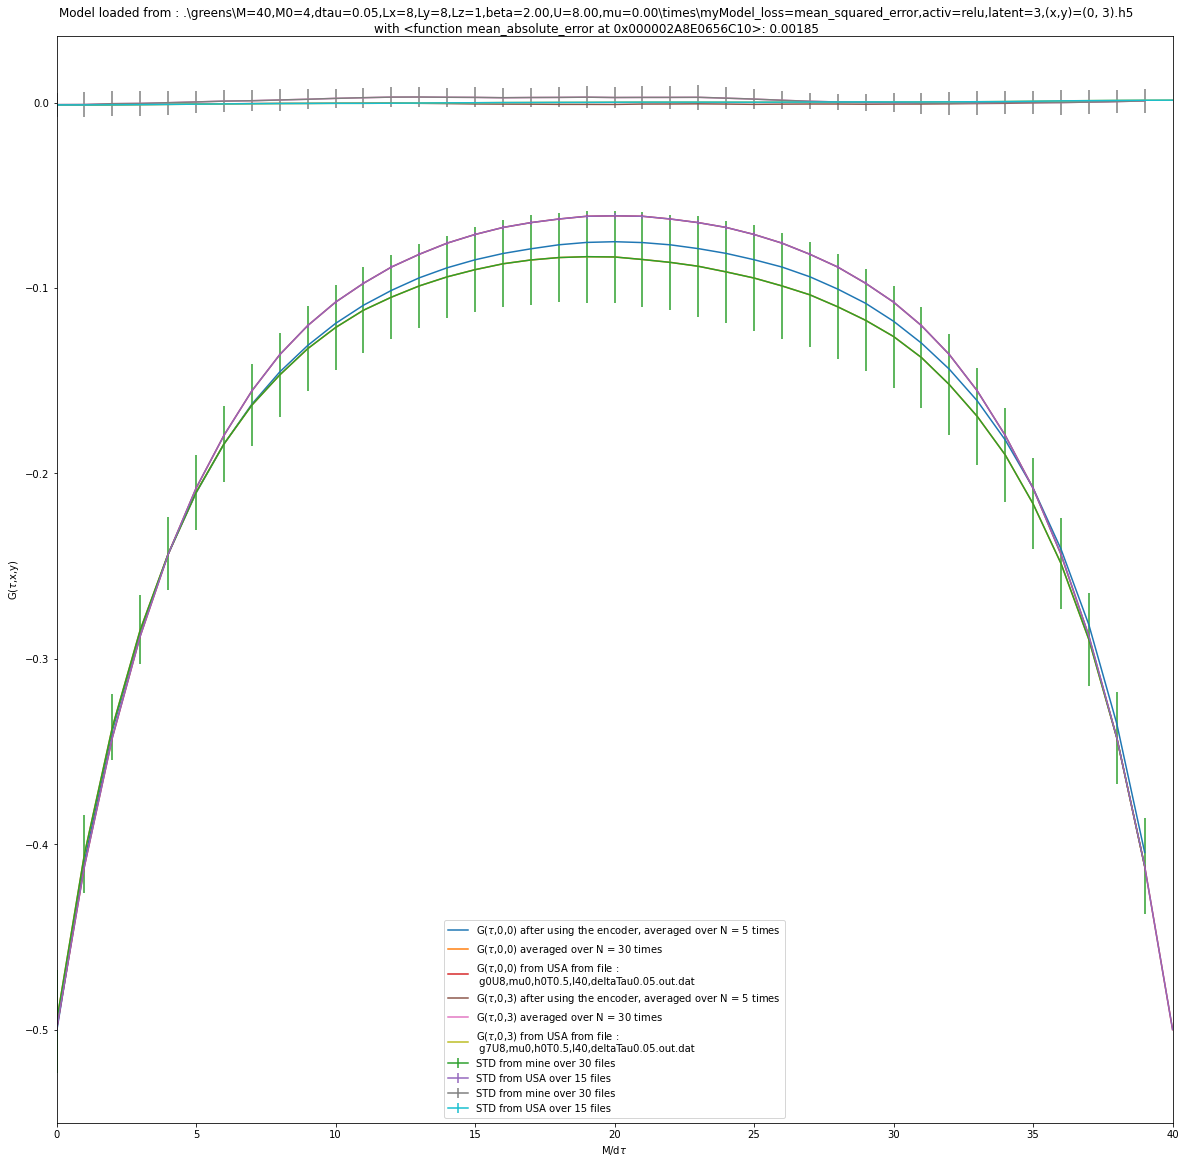

In [46]:


trainSiz = 500
subplts =  plt.subplots(figsize=(20,20))


x = 0
y = 0

network = compareAutoencoder_Average(resultsFolder,subplts=subplts, model = model2,\
                           load_model = True, latent_dim = 3,\
                           epo = 300, batch = 40, trainsize = trainSiz,\
                           testsize = 50, avNum = 30 ,encoderAvNum = 5, x = x, y = y, verbose = 1,\
                           createFiles=False, loss = 'mean_squared_error',\
                           activation = 'relu', scale = False, difference = mean_absolute_error, theirError=15, myError=True)

x = 0
y = 3
network = compareAutoencoder_Average(resultsFolder,subplts=subplts, model = model2,\
                           load_model = True, latent_dim = 3,\
                           epo = 300, batch = 40, trainsize = trainSiz,\
                           testsize = 50, avNum = 30 ,encoderAvNum = 5, x = x, y = y, verbose = 1,\
                           createFiles=False, loss = 'mean_squared_error',\
                           activation = 'relu', scale = False, difference = mean_absolute_error, theirError=15, myError=True)
plt.show()
tmp_dir = resultsFolder + f'\\results\\square\\2D\\Lx=8,Ly=8,Lz=1\\greens\\M=40,M0=4,dtau=0.05,Lx=8,Ly=8,Lz=1,beta=2.00,U=8.00,mu=0.00\\times\\posDiff\\(0, 0)\\594-upgreensTime.dat'

